# CNN

Here I've coded a neural network with arbitrary structure. It can be run as a simple ANN or a CNN. In order to construct the object, first build a list of layers (filter, pool, connection) to use in initializing the network. Examples are given below. Currently, an arbitrary number of connection layers definitely works, but I am unsure if one can layer a filter, pool, filter, connection successfully. Given more time, I would test this architecture for robustness and implementation, but as of the moment I have not successfully constructed a filter-pool, filter-pool, connection architecture using this code.

The CNN architecture with one filter, one pool, then one regular connected layer operates well and achieves 96-98% accuracy with the Digits data, and 92%+ with MNIST with a suboptimal lr in favor of submitting the project asap.

For future developments, I'd like to explore how the number of filters

## Load Data Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

def read_dataset(feature_file, label_file): 
    ''' Read data set in *.csv to data frame in Pandas'''
    df_X = pd.read_csv(feature_file)
    df_y = pd.read_csv(label_file)
    X = df_X.values # convert values in dataframe to numpy array (features)
    y = df_y.values # convert values in dataframe to numpy array (label)
    return X, y


def normalize_features(X_train, X_test):
    from sklearn.preprocessing import StandardScaler #import libaray
    scaler = StandardScaler() # call an object function
    scaler.fit(X_train) # calculate mean, std in X_train
    X_train_norm = scaler.transform(X_train) # apply normalization on X_train
    X_test_norm = scaler.transform(X_test) # we use the same normalization on X_test
    return X_train_norm, X_test_norm


def one_hot_encoder(y_train, y_test):
    ''' convert label to a vector under one-hot-code fashion '''
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    y_train_ohe = lb.transform(y_train)
    y_test_ohe = lb.transform(y_test)
    return y_train_ohe, y_test_ohe

# Filter Architecture

These classes define each kind of layer and their respective functionality. CInfo contains the information for each layer, for example the dimensions of the filter or pool, the stride count, number of neurons, or activation function. CLayer is used within the CNN class in order to construct the proper layers. 

CFilter is a convolution layer, CPool a pooling layer, and CConnection is the connected layer used in a regular ANN. See example below for how to construct them properly.

Each type of layer has three basic functions beyond initialization functions, mainly FeedForward, FeedBack (backprop), and Print. Feedforward feeds the data forward through the layer; FeedBack is used to propagate error backward; Print merely print the details of each layer to screen for information or troubleshooting purposes. 

In [2]:
class CFunction:
    def __init__(self,Function,Derivative):
        self.f = Function
        self.d = Derivative
        
def FRELU(X):
    a = np.copy(X)
    a[X<0]=0
    return a
def FRELU_dx(X):
    dx = np.zeros(X.shape)
    dx[X>0] = 1
    return dx


RELU  = CFunction(FRELU,FRELU_dx)

class CLayer:
    def __init__(self,Tag,Info):
        self.tag = Tag
        self.info = Info
        self.indim = None
        self.outdim = None
        
class CInfo:
    def __init__(self,dimensions=None,stride_i=1,stride_j=1,activation=RELU):
        self.dimensions = dimensions
        self.stride_i = stride_i
        self.stride_j = stride_j
        self.activation = activation
    def FAddDimensions(self,Dimensions):
        self.dimensions = Dimensions
    def FAddStride(self,Stride_i=1,Stride_j=1):
        self.stride_i = Stride_i
        self.stride_j = Stride_j
    def FAddActivation(self,Activation):
        self.activation = Activation
        
class CFilter:
    def __init__(self,info):
        self.tag = "convolution"
        self.dimensions = info.dimensions
        self.num_filt = info.dimensions[0]
        self.num_ch = info.dimensions[1]
        self.f_i = info.dimensions[2]
        self.f_j = info.dimensions[3]
        self.weight = self.FInitializeFilter()
        self.bias = self.FInitializeBias()
        self.stride_i = info.stride_i
        self.stride_j = info.stride_j
        self.activation = info.activation        
    def FInitializeFilter(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.dimensions))),size=self.dimensions)
    def FInitializeBias(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.num_filt))),size=(1,self.num_filt))
    
    def FFeedForward(self,images):
        (num_imag, num_ch, imag_i, imag_j) = images.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the filter does not match the number of channels in the images!")

        out_i = int(np.ceil((imag_i - self.f_i)/self.stride_i) + 1)
        out_j = int(np.ceil((imag_j - self.f_j)/self.stride_j) + 1)
        z = np.zeros((num_imag, self.num_filt, out_i, out_j))
        i=0
        for image in images:
            for curr_f in range(self.num_filt):
                curr_y = curr_y_end = out_y = 0
                f_y_end = self.f_j
                while(out_y < out_j):
                    curr_x = curr_x_end = out_x = 0
                    curr_y_end = curr_y + self.f_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                        f_y_end = curr_y_end - curr_y
                    f_x_end = self.f_i
                    while(out_x < out_i):
                        curr_x_end = curr_x + self.f_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                            f_x_end = curr_x_end - curr_x
                        z[i,curr_f,out_x,out_y] = np.sum(image[:,curr_x:curr_x_end,curr_y:curr_y_end]*self.weight[curr_f,:,0:f_x_end,0:f_y_end]) + self.bias[0][curr_f]
                        curr_x += self.stride_i
                        out_x += 1
                    curr_y += self.stride_j
                    out_y += 1
            i+=1
        return z,self.activation.f(z)
    
    def FFeedBack(self,dprev,imag_in):
        (num_imag, num_ch, imag_i, imag_j) = imag_in.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the filter does not match the number of channels in the input!")

        dout = np.zeros((num_imag,num_ch,imag_i,imag_j))
        dfilt = np.zeros(self.weight.shape)
        dbias = np.zeros((1,self.num_filt))

        for i in range(imag_in.shape[0]):
            for curr_f in range(self.num_filt):
                curr_y = out_y = 0
                f_y_end = self.f_i
                while(curr_y + self.f_j < imag_j + 1):
                    curr_x = out_x = 0
                    curr_y_end = curr_y + self.f_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                        f_y_end = curr_y_end - curr_y + 1
                    f_x_end = self.f_j
                    while(curr_x + self.f_i < imag_i + 1): 
                        curr_x_end = curr_x + self.f_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                            f_x_end = curr_x_end - curr_x + 1                      
                        dout[i,:,curr_x:curr_x_end,curr_y:curr_y_end] += dprev[i,curr_f, out_x, out_y] * self.weight[curr_f,:,:f_x_end,:f_y_end]
                        dfilt[curr_f,:,:f_x_end,:f_y_end] += dprev[i,curr_f,out_x,out_y] * imag_in[i,:,curr_x:curr_x_end,curr_y:curr_y_end]

                        curr_x += self.stride_i
                        out_x +=1
                    curr_y += self.stride_j
                    out_y += 1
                dbias[0][curr_f] += np.sum(dprev[i,curr_f])
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('imag_in\n',imag_in) 
        print('dfilt\n',dfilt)
        print('dbias\n',dbias)
        '''
        return dout,dfilt,dbias

    def FPrint(self):
        print("Filter Information:")
        print("  tag:",self.tag)
        print("  num_filt:",self.num_filt)
        print("  num_ch:",self.num_ch)
        print("  f_i:",self.f_i)
        print("  f_j:",self.f_j)
        print("  stride_i:",self.stride_i)
        print("  stride_j:",self.stride_j)
        #print("  act.f:",self.activation.f)
        #print("  act.d:",self.activation.d)
        print("  filt:\n",self.weight)
        print("  bias:\n",self.bias)

class CPool:
    def __init__(self,info):
        self.tag = "pool"
        self.dimensions = info.dimensions
        self.num_ch = info.dimensions[0]
        self.pool_i = info.dimensions[1]
        self.pool_j = info.dimensions[2]
        self.stride_i = info.stride_i
        self.stride_j = info.stride_j  
        
    def FFeedForward(self,images):
        (num_imag, num_ch, imag_i, imag_j) = images.shape

        if(self.num_ch != num_ch):
            print("Big mistake! The number of channels in the pool does not match the number of channels in the input!")

        out_i = int(np.ceil((imag_i - self.pool_i)/self.stride_i)) + 1
        out_j = int(np.ceil((imag_j - self.pool_j)/self.stride_j)) + 1
        z = np.zeros((num_imag, num_ch, out_i, out_j))

        i=0
        for image in images:
            for curr_chan in range(self.num_ch):
                curr_y = out_y = 0
                while(out_y < out_j):
                    curr_x = out_x = 0
                    curr_y_end = curr_y + self.pool_j
                    if(curr_y_end > imag_j):
                        current_y_end = imag_j
                    while(out_x < out_i):
                        curr_x_end = curr_x + self.pool_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                        z[i,curr_chan,out_x,out_y] = np.max(image[curr_chan, curr_x:curr_x_end, curr_y:curr_y_end])
                        curr_x += self.stride_i
                        out_x +=1
                    curr_y += self.stride_j
                    out_y += 1
            i+=1
        return z,z

    def FFeedBack(self, dprev, imag_in):
        (num_imag_p, num_ch_p, dp_i, dp_j) = dprev.shape
        (num_imag, num_ch, imag_i, imag_j) = imag_in.shape

        if(num_ch_p != num_ch):
            print("Big mistake! The number of channels in dpool does not match the number of channels in the input!")

        dout = np.zeros((num_imag, num_ch,imag_i,imag_j))
        for i in range(imag_in.shape[0]):
            for curr_ch in range(num_ch):
                curr_y = curr_y_end = out_y = 0
                while(out_y < dp_j):
                    curr_x = curr_x_end = out_x = 0
                    curr_y_end = curr_y + self.pool_j
                    if(curr_y_end > imag_j):
                        curr_y_end = imag_j
                    while(out_x < dp_i):
                        curr_x_end = curr_x + self.pool_i
                        if(curr_x_end > imag_i):
                            curr_x_end = imag_i
                        (a,b) = np.unravel_index(np.nanargmax(imag_in[i,curr_ch,curr_x:curr_x_end,curr_y:curr_y_end]),imag_in[i,curr_ch,curr_x:curr_x_end,curr_y:curr_y_end].shape)
                        dout[i,curr_ch,curr_x+a,curr_y+b] += dprev[i,curr_ch,out_x,out_y]

                        curr_x += self.stride_i
                        out_x += 1
                    curr_y += self.stride_j
                    out_y += 1
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('imag_in\n',imag_in)
        '''
        return dout

    def FPrint(self):
        print("Pool Information:")
        print("  tag:",self.tag)
        print("  pool_i:",self.pool_i)
        print("  pool_j:",self.pool_j)
        print("  stide_i:",self.stride_i)
        print("  stride_j:",self.stride_j)

class CConnection:
    def __init__(self,info):
        self.tag = "connection"
        self.dimensions = info.dimensions
        self.neurons_in = info.dimensions[0]
        self.neurons_out = info.dimensions[1]
        self.weight = self.FInitializeWeights()
        self.bias = self.FInitializeBias()
        self.activation = info.activation
   
    def FInitializeWeights(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod([self.neurons_in,self.neurons_out]))),size=[self.neurons_in,self.neurons_out])
       
    def FInitializeBias(self):
        return np.random.normal(loc=0,scale=1.0/(np.sqrt(np.prod(self.neurons_out))),size=(1,self.neurons_out))

    def FFeedForward(self,images):
        z = images.dot(self.weight) + self.bias
        return z, self.activation.f(z)
    
    def FFeedBack(self,dprev,data_in):
        dW = self.activation.f(data_in).T.dot(dprev)
        db = np.sum(dprev,axis=0,keepdims=True)
        dout = dprev.dot(self.weight.T)*self.activation.d(data_in)
        '''
        print('')
        self.FPrint()
        print('dprev\n',dprev)
        print('f(data)\n',self.activation.f(data_in))
        print('d(data)\n',self.activation.d(data_in))
        print('weight\n',self.weight)
        print('bias\n',self.bias)
        print('dW\n',dW)
        print('db\n',db)
        '''
        return dout, dW, db

    def FPrint(self):
        print("Connection Information:")
        print("  tag:",self.tag)
        print("  neurons_in:",self.neurons_in)
        print("  neurons_out:",self.neurons_out)
        #print("  act.f:",self.activation.f)
        #print("  act.d:",self.activation.d)
        print("  weights:\n",self.weight)
        print("  bias:\n",self.bias)

# Functions

Basic function definitions, and definition of the CFunction class to combine together a function and its derivative for easier reference.

In [3]:


def RegularizedLoss(y,yhat,regularization_parameter,C):
    loss = 0
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    hinge[hinge<0]=0
    loss = np.sum(hinge)
    loss *= regularization_parameter
    temp = 0
    for item in C:
        for elem in item:
            temp += np.sum(elem*elem)
    return loss + np.sqrt(temp)

def RegularizedLoss_dx(y,yhat,regularization_parameter):
    hinge = 1 - y*yhat
    hinge = np.sum(hinge,axis=1,keepdims=True)
    summed = np.sum(y*yhat,axis=1,keepdims=True)
    loss = np.zeros(y.shape)
    for i in range(hinge.shape[0]):
        if(hinge[i]>0):
            loss[i] = yhat[i]*(summed[i] - y[i])
    loss *= regularization_parameter
    return loss

def softmax(z):
    exp_value = np.exp(z-np.amax(z, axis=1, keepdims=True)) # for stablility
    # keepdims = True means that the output's dimension is the same as of z
    softmax_scores = exp_value / np.sum(exp_value, axis=1, keepdims=True)
    return softmax_scores
def accuracy(ypred, yexact):
    p = np.array(ypred == yexact, dtype = int)
    return np.sum(p)/float(len(yexact))


REGU = CFunction(RegularizedLoss,RegularizedLoss_dx)

# Convolutional Neural Network Definition

In [4]:
class CNN:
    def __init__(self, indim, outdim, LayersInfo, lr=0.1, rp=0.1):
        self.in_ch = []
        self.indim_i = []
        self.indim_j = []
        self.in_ch.append(indim[0])
        self.indim_i.append(indim[1])
        self.indim_j.append(indim[1])
        self.outdim = outdim

        #self.X = X
        #self.X_reshape = self.X.reshape(self.samples,self.in_ch[0],self.indim_i[0],self.indim_j[0])
        #self.y = y
        self.lr = lr
        self.rp = rp
        self.probability = softmax

        self.layer = []
        for Layer in LayersInfo:
            self.layer.append(self.FAddLayer(Layer))
        outinfo = CInfo([-1,self.outdim])
        finallayer = CLayer('connection',outinfo)
        self.layer.append(self.FAddLayer(finallayer))
            

    def FAddLayer(self,Layer):
        if(Layer.tag=='convolution'):
            Layer.info.dimensions[1] = self.in_ch[-1]
            self.in_ch.append(Layer.info.dimensions[0])
            f_i = Layer.info.dimensions[2]
            f_j = Layer.info.dimensions[3]
            stride_i = Layer.info.stride_i
            stride_j = Layer.info.stride_j
            indim_i = self.indim_i[-1]
            indim_j = self.indim_j[-1]
            self.indim_i.append(int(np.ceil((indim_i - f_i)/stride_i) + 1))
            self.indim_j.append(int(np.ceil((indim_j - f_j)/stride_j) + 1))
            return CFilter(Layer.info)
        elif(Layer.tag=='pool'):
            Layer.info.dimensions[0] = self.in_ch[-1]
            p_i = Layer.info.dimensions[1]
            p_j = Layer.info.dimensions[2]
            stride_i = Layer.info.stride_i
            stride_j = Layer.info.stride_j
            indim_i = self.indim_i[-1]
            indim_j = self.indim_j[-1]
            self.in_ch.append(self.in_ch[-1])
            self.indim_i.append(int(np.ceil((indim_i - p_i)/stride_i) + 1))
            self.indim_j.append(int(np.ceil((indim_j - p_j)/stride_j) + 1))
            return CPool(Layer.info)
        elif(Layer.tag=='connection'):
            flatten = self.in_ch[-1]*self.indim_i[-1]*self.indim_j[-1]
            Layer.info.dimensions[0] = flatten
            self.in_ch.append(1)
            self.indim_i.append(1)
            self.indim_j.append(Layer.info.dimensions[1])
            return CConnection(Layer.info)
        else:
            print(Layer.tag,'is not a valid layer option. Double check initialization.')
            return None

    def FPrint(self):
        for l in self.layer:
            l.FPrint()

    def FFeedForward(self,X):
        self.z = []
        self.f = []
        images = X.reshape(X.shape[0],self.in_ch[0],self.indim_i[0],self.indim_j[0])
        self.f.append(images)
        for i in range(0,len(self.layer)):
            if(self.layer[i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            Z,F = self.layer[i].FFeedForward(images)
            self.z.append(Z)
            if(i != len(self.layer) -1):
                self.f.append(F)
            images = self.f[-1]
            '''
            print('')
            print(self.layer[i].FPrint())
            print('z',Z)
            print('f',F)
            '''
        self.yhat = self.probability(self.z[-1])
        
    def FBackPropagation(self,y):
        d = []
        d.insert(0,self.Loss_dx(y,self.yhat)) 
        #print('dout\n',d[0])
        for i in range(len(self.layer)):
            images = self.f[-1-i]
            if(self.layer[-1-i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            elif(self.layer[-1-i+1].tag == 'connection'):
                d[0] = np.reshape(d[0],(images.shape[0],self.in_ch[-1-i],self.indim_i[-1-i],self.indim_j[-1-i]))
            if(self.layer[-1-i].tag != 'pool'):
                dout,dW,db = self.layer[-1-i].FFeedBack(d[0],images)
                #dW /= float(len(y))
                #db /= float(len(y))
                self.layer[-1-i].weight = self.layer[-1-i].weight - self.lr*dW
                if(self.rp != 0 and self.layer[-1-i].weight.all() !=0 ):
                    self.layer[-1-i].weight = self.layer[-1-i].weight - self.rp*self.layer[-1-i].weight/np.sqrt(np.sum(self.layer[-1-i].weight*self.layer[-1-i].weight))/self.layer[-1-i].weight.size

                self.layer[-1-i].bias = self.layer[-1-i].bias - self.lr*db
                if(self.rp != 0 and self.layer[-1-i].bias.all() !=0 ):
                    self.layer[-1-i].bias = self.layer[-1-i].bias - self.rp*self.layer[-1-i].bias/np.sqrt(np.sum(self.layer[-1-i].bias*self.layer[-1-i].bias))/self.layer[-1-i].bias.size  
            else:
                dout = self.layer[-1-i].FFeedBack(d[0],self.f[-1-i])
                
            d.insert(0,dout)
            #print('dout\n',d[0])
            
    def Loss(self,y,yhat):
        loss = 0
        hinge = 1 - y*yhat
        hinge = np.sum(hinge,axis=1,keepdims=True)
        hinge[hinge<0]=0
        loss = np.sum(hinge)
        loss *= self.rp
        temp = 0
        for l in self.layer:
            if(l.tag != 'pool'):
                temp += np.sum(l.weight*l.weight)
                temp += np.sum(l.bias*l.bias)
        return loss + np.sqrt(temp)

    def Loss_dx(self,y,yhat):
        hinge = 1 - y*yhat
        #print('hinge\n',hinge)
        hinge = np.sum(hinge,axis=1,keepdims=True)
        #print('hinge\n',hinge)
        summed = np.sum(y*yhat,axis=1,keepdims=True)
        #print('summed\n',summed)
        loss = np.zeros(y.shape)
        for i in range(hinge.shape[0]):
            if(hinge[i]>0):
                loss[i] = yhat[i]*(summed[i] - y[i])
        #print('dloss\n',loss)
        loss *= self.rp
        #print('dloss\n',loss)
        return loss   
    
    def FPredict(self, X_test):
        images = X_test.reshape(X_test.shape[0],self.in_ch[0],self.indim_i[0],self.indim_j[0])
        f = images
        for i in range(0,len(self.layer)):
            if(self.layer[i].tag == 'connection'):
                images = np.reshape(images,(images.shape[0],-1))
            Z,F = self.layer[i].FFeedForward(images)
            images = F
        yhat = self.probability(Z)
       
        # the rest is similar to the logistic regression
        labels = np.arange(0,self.outdim+1)
        num_test_samples = X_test.shape[0]
        # find which index gives us the highest probability
        ypred = np.zeros(num_test_samples, dtype=int)
        for i in range(num_test_samples):
            ypred[i] = labels[np.argmax(yhat[i,:])]
        return ypred

    def FTrain(self,epochs,batchsize,X,y,Xtest,ytest):
        batches = int(np.ceil(X.shape[0]/batchsize))
        for i in range(epochs):
            for j in range(batches):
                start = j*batchsize
                end = start + batchsize
                if(end > X.shape[0]):
                    end = X.shape[0]
                X_ = X[start:end]
                y_ = y[start:end]
                self.FFeedForward(X_)
                self.FBackPropagation(y_)
            if((i+1)%(epochs/10) == 0):
                ypred = self.FPredict(Xtest)
                print(i+1,accuracy(ypred.ravel(),ytest.ravel()),'\n  Loss: ',self.Loss(y_,self.yhat))

In [5]:
def plot_digit(feature_vector):
    dim = int(np.sqrt(len(feature_vector)))
    plt.gray()
    plt.matshow(feature_vector.reshape(dim,dim))
    plt.show()
    
def plot_test(index1,index2,clearn_,Xp,Xt,y):
    for index in range(index1,index2):
        print('Image:',index)
        plot_digit(Xp[index])
        ypred = clearn_.FPredict(Xt[index].reshape(1,-1))
        print('Label:', int(y[index]))
        print('Prediction:',int(ypred))
        print('')

# Digits with 8 Filters

In order to arrange and run the CNN, first create the layers. To do so, you must first create a CInfo object, which stores the dimensions and other data necessary for the layer. By default, the stride is set to one and the activation is set to RELU, so only the dimensions are necessary for creation. For a filter, the dimensions are [num_filters, num_channels, x-dim, y-dim]. Note I've set the num_channels to -1 since the program will automatically set this from the data itself. This is true for all -1 values below. For a pool layer, set the dimensions as [num_channels, x-dim, y-dim], then stride_i, stride_j. A Connecting layer is [data_size_in, neurons_out]. Once the CInfo is constructed, create a CLayer object with the tag, 'convolution', 'pool', or 'connection' along with the info. Create a list of these CLayer objects and then use this to create the CNN.

The CNN requires a list of the data dimensions (num_channels, x-dim, y-dim), the number of classifiers, a list of layers, the lr, and the reg param. Note the lr = rp = 0.1 by default. Next, call FTrain with the number of epochs, the batchsize, and the associated training and test data. 

In [6]:
dX_train, dy_train = read_dataset('Digits_X_train.csv', 'Digits_y_train.csv')
dX_test, dy_test = read_dataset('Digits_X_test.csv', 'Digits_y_test.csv')
dX_train_norm, dX_test_norm = normalize_features(dX_train, dX_test)
dy_train_ohe, dy_test_ohe = one_hot_encoder(dy_train, dy_test)

# [num_filters, num_channels, x-dim, y-dim]
filt1_info = CInfo([8,-1,3,3])  
filt1 = CLayer('convolution',filt1_info)

# [num_channels, x-dim, y-dim], stride_i, stride_j
pool1_info = CInfo([-1,2,2],2,2) 
pool1 = CLayer('pool',pool1_info)

#filt2_info = CInfo([8,-1,3,3])
#filt2 = CLayer('convolution',filt2_info)

#pool2_info = CInfo([-1,2,2],2,2)
#pool2 = CLayer('pool',pool2_info)

# [input vector size, neurons/output vector size]
conn_info = CInfo([-1,100])
conn = CLayer('connection',conn_info)

# data here is grayscale, so channels = 1
# image dimension here is square, so x-dim = y-dim
# 10 classifiers in 0-9 digits
# dimensions list
# layers list
# learning rate
# reg param
im_channels = 1
im_dim = int(np.sqrt(dX_train.shape[1]))
out_class = 10
dim = [im_channels,im_dim,im_dim]
layers=[filt1,pool1,conn]
lr = 0.02
rp = 0.1

digitscnn1 = CNN(dim,out_class,layers,lr,rp)

epochs = 200
batches = 10
batchsize = int (np.ceil(dX_train_norm.shape[0]/batches))
digitscnn1.FTrain(epochs,\
           batchsize,\
           dX_train_norm,\
           dy_train_ohe,\
           dX_test_norm,\
           dy_test)

20 0.3844444444444444 
  Loss:  132.5226468689818
40 0.72 
  Loss:  127.91862866207184
60 0.84 
  Loss:  127.13746347586766
80 0.8444444444444444 
  Loss:  127.41016614291216
100 0.8511111111111112 
  Loss:  127.65324856560848
120 0.86 
  Loss:  127.83772888492143
140 0.86 
  Loss:  127.98097153305454
160 0.8555555555555555 
  Loss:  128.08634031656206
180 0.8577777777777778 
  Loss:  128.17416001394534
200 0.8577777777777778 
  Loss:  128.17307107961668


# Digits with 4 filters

Reducing the number of filters seems to increase stability. With 8 filters, my accuracy ranged from 85-96%. With 4, it seems much more stable in settling from 95-97%. Note below it ended training at 96%, but seems to have had room to grow with additional training.

In [7]:
dX_train, dy_train = read_dataset('Digits_X_train.csv', 'Digits_y_train.csv')
dX_test, dy_test = read_dataset('Digits_X_test.csv', 'Digits_y_test.csv')
dX_train_norm, dX_test_norm = normalize_features(dX_train, dX_test)
dy_train_ohe, dy_test_ohe = one_hot_encoder(dy_train, dy_test)

filt1_info = CInfo([4,-1,3,3])
filt1 = CLayer('convolution',filt1_info)

pool1_info = CInfo([-1,2,2],2,2)
pool1 = CLayer('pool',pool1_info)

conn_info = CInfo([-1,50])
conn = CLayer('connection',conn_info)

im_channels = 1
im_dim = int(np.sqrt(dX_train.shape[1]))
out_class = 10
dim = [im_channels,im_dim,im_dim]
layers=[filt1,pool1,conn]
lr = 0.02
rp = 0.1

digitscnn2 = CNN(dim,out_class,layers,lr,rp)

epochs = 200
batches = 10
batchsize = int (np.ceil(dX_train_norm.shape[0]/batches))
digitscnn2.FTrain(epochs,\
           batchsize,\
           dX_train_norm,\
           dy_train_ohe,\
           dX_test_norm,\
           dy_test)

20 0.18 
  Loss:  132.37245725916438
40 0.7488888888888889 
  Loss:  128.4955164284428
60 0.9288888888888889 
  Loss:  126.6923475984547
80 0.9488888888888889 
  Loss:  127.00543919281978
100 0.9511111111111111 
  Loss:  127.34875825490293
120 0.9488888888888889 
  Loss:  127.62579541926175
140 0.9466666666666667 
  Loss:  127.8350780177981
160 0.9511111111111111 
  Loss:  128.0226547213867
180 0.9555555555555556 
  Loss:  128.2145008809032
200 0.9577777777777777 
  Loss:  128.3985114947536


# MNIST 4 filters

Following the performance of the Digits data with 4 filters, I tried MNIST with four as well. I chose a purposefully high learning rate and short number of epochs to quickly test the algorithm on the MNIST in order to submit it as soon as possible. I'd be interested to see how well it performs given more time to run, but currently it achieves 92%+ accuracy. 

In [13]:
mX_train, my_train = read_dataset('MNIST_X_train.csv', 'MNIST_y_train.csv')
mX_test, my_test = read_dataset('MNIST_X_test.csv', 'MNIST_y_test.csv')
mX_train_norm, mX_test_norm = normalize_features(mX_train, mX_test)
my_train_ohe, my_test_ohe = one_hot_encoder(my_train, my_test)


filt1_info = CInfo([4,-1,8,8])
filt1 = CLayer('convolution',filt1_info)

pool1_info = CInfo([-1,2,2],2,2)
pool1 = CLayer('pool',pool1_info)


conn_info = CInfo([-1,50])
conn = CLayer('connection',conn_info)

im_channels = 1
im_dim = int(np.sqrt(mX_train.shape[1]))
out_class = 10
dim = [im_channels,im_dim,im_dim]
layers=[filt1,pool1,conn]
lr = 0.1
rp = 0.1

mnistcnn = CNN(dim,out_class,layers,lr,rp)

epochs = 20
batches = 10
batchsize = int (np.ceil(mX_train_norm.shape[0]/batches))
mnistcnn.FTrain(epochs,\
           batchsize,\
           mX_train_norm,\
           my_train_ohe,\
           mX_test_norm,\
           my_test)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


2 0.572 
  Loss:  195.2751342529385
4 0.836 
  Loss:  191.16459475246842
6 0.84 
  Loss:  189.83529001988006
8 0.798 
  Loss:  190.40697249851206
10 0.858 
  Loss:  190.51422370200905
12 0.872 
  Loss:  190.3685544307058
14 0.872 
  Loss:  190.31602353280942
16 0.864 
  Loss:  191.25224551251915
18 0.888 
  Loss:  190.69449337319372
20 0.918 
  Loss:  190.75382862940094


In [9]:
def plot_digit(feature_vector):
    dim = int(np.sqrt(len(feature_vector)))
    plt.gray()
    plt.matshow(feature_vector.reshape(dim,dim))
    plt.show()
    
def plot_test(index1,index2,clearn_,Xp,Xt,y):
    for index in range(index1,index2):
        print('Image:',index)
        plot_digit(Xp[index])
        ypred = clearn_.FPredict(Xt[index].reshape(1,-1))
        print('Label:', int(y[index]))
        print('Prediction:',int(ypred))
        print('')


digits1cnn
Image: 0


<Figure size 432x288 with 0 Axes>

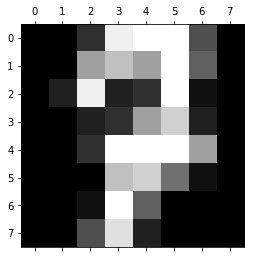

Label: 7
Prediction: 7

Image: 1


<Figure size 432x288 with 0 Axes>

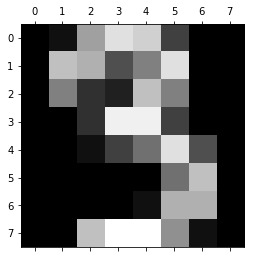

Label: 3
Prediction: 3

Image: 2


<Figure size 432x288 with 0 Axes>

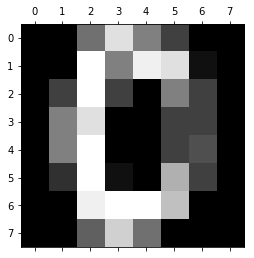

Label: 0
Prediction: 0

Image: 3


<Figure size 432x288 with 0 Axes>

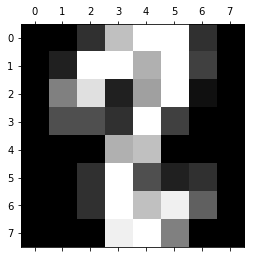

Label: 2
Prediction: 2

Image: 4


<Figure size 432x288 with 0 Axes>

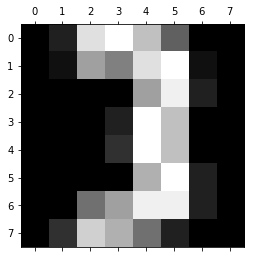

Label: 3
Prediction: 3



In [11]:
print('digits1cnn')
plot_test(0,5,digitscnn1,dX_test,dX_test_norm,dy_test)

digits2cnn
Image: 0


<Figure size 432x288 with 0 Axes>

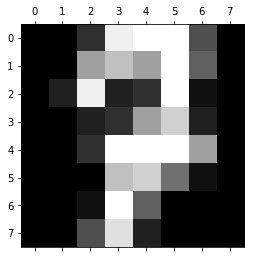

Label: 7
Prediction: 7

Image: 1


<Figure size 432x288 with 0 Axes>

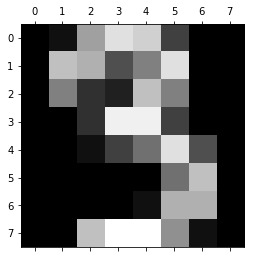

Label: 3
Prediction: 3

Image: 2


<Figure size 432x288 with 0 Axes>

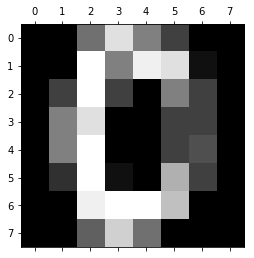

Label: 0
Prediction: 0

Image: 3


<Figure size 432x288 with 0 Axes>

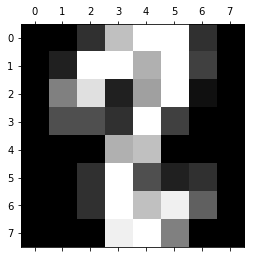

Label: 2
Prediction: 2

Image: 4


<Figure size 432x288 with 0 Axes>

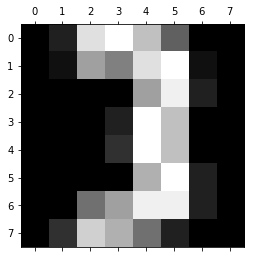

Label: 3
Prediction: 3



In [12]:
print('digits2cnn')
plot_test(0,5,digitscnn2,dX_test,dX_test_norm,dy_test)

mnistcnn
Image: 0


<Figure size 432x288 with 0 Axes>

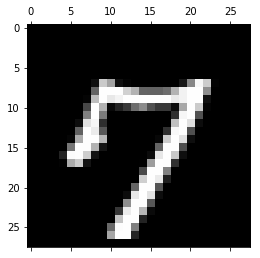

Label: 7
Prediction: 7

Image: 1


<Figure size 432x288 with 0 Axes>

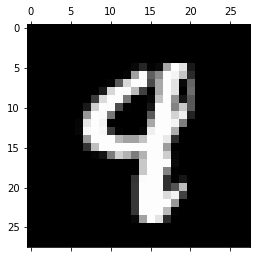

Label: 9
Prediction: 9

Image: 2


<Figure size 432x288 with 0 Axes>

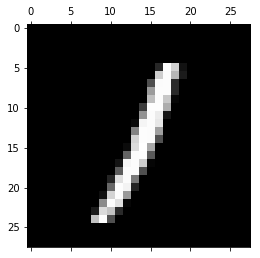

Label: 1
Prediction: 1

Image: 3


<Figure size 432x288 with 0 Axes>

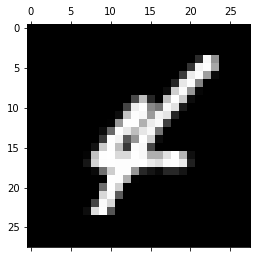

Label: 4
Prediction: 4

Image: 4


<Figure size 432x288 with 0 Axes>

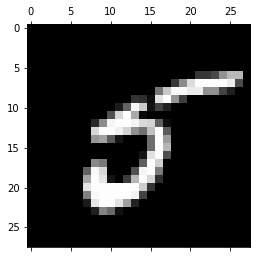

Label: 5
Prediction: 5



In [25]:
print('mnistcnn')
plot_test(0,5,mnistcnn,mX_test,mX_test_norm,my_test)